In [17]:
## import libraries

import os
import random
import zlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage.feature import canny
from pathlib import Path


import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage.draw import line as draw_line

import json

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from typing import Tuple, Optional

from PIL import Image
import statsmodels.formula.api as smf

In [18]:
## define filepaths

project_path =  Path().resolve().parent
tables_path = os.path.join(project_path, "015_tables")
raw_data_path = os.path.join(project_path, "005_cleaned_data")
raw_data_path_targets = os.path.join(project_path, "007_targets")
viz_path = os.path.join(project_path, "020_visualizations")

print(project_path)

E:\Research2\VizEx_analysis_replication


In [19]:
# Automatically reload updated code from utils/*.py every time you run a cell
%load_ext autoreload
%autoreload 2

# Add the parent directory to the Python path (only needed if utils is not already importable)
import sys
from pathlib import Path
if str(project_path) not in sys.path:
    sys.path.append(str(project_path))

from utils.utils import *
from utils.detail_feature import *
from utils.viz import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# -------------------------------
# Load CSVs and register datasets
# (VizEx single-experiment version)
# -------------------------------

# Paths to CSV files
vizex_csv_path = os.path.join(tables_path, "vizex_features.csv")
vizex_targets_csv_path = os.path.join(tables_path, "vizex_targets_features.csv")

# Read CSVs
df_vizex = pd.read_csv(vizex_csv_path)
df_vizex_targets = pd.read_csv(vizex_targets_csv_path)

# Create working copies (this is where we’ll add focal points + feature columns)
df_vizex_features = df_vizex.copy(deep=True)
df_vizex_targets_features = df_vizex_targets.copy(deep=True)

# Quick checks
display(df_vizex.head())
display(df_vizex_targets.head())

# Image roots (edit these if your on-disk folder names differ)
raw_data_path_vizex = raw_data_path                 # participant images
raw_data_path_targets_vizex = raw_data_path_targets # target images

image_paths = {
    "vizex": raw_data_path_vizex,
    "vizex_targets": raw_data_path_targets_vizex,
}

# Dataset registry
# - dataset_id: selects dataframe + image path
# - domain_key: selects preprocessing conventions (now just 'vizex')
datasets = {
    "vizex": {
        "name": "VizEx",
        "domain_key": "vizex",
        "df_raw": df_vizex,
        "df": df_vizex_features,          # working df
        "image_path": image_paths["vizex"],
    },
    "vizex_targets": {
        "name": "VizEx Targets",
        "domain_key": "vizex",            # IMPORTANT: preprocess like vizex
        "df_raw": df_vizex_targets,
        "df": df_vizex_targets_features,
        "image_path": image_paths["vizex_targets"],
    },
}

# Sanity checks: required columns
REQUIRED_COLS = ["png_filename"]
for k, ds in datasets.items():
    missing = [c for c in REQUIRED_COLS if c not in ds["df"].columns]
    if missing:
        raise KeyError(f"Dataset '{k}' is missing required columns in df: {missing}")

# Sanity checks: image_path exists
for k, ds in datasets.items():
    if not os.path.isdir(ds["image_path"]):
        print(f"WARNING: image_path not found for '{k}': {ds['image_path']}")


,participant_code,condition_code,condition_name,condition_hz,condition_type,stimulus_type,trialn,png_filename,focal_x_norm,focal_y_norm,detail_raw,detail,r_directionality_raw,r_directionality,theta_directionality_raw,theta_directionality,brightness_raw,brightness,contrast_raw,contrast
0,TKB3728,7,80 Hz,80.0,CONTROL,LIGHT,2,saveTime_2510171012__sessionTime_202510170920_...,0.0,0.0,0.000837,0.038183,0.058464,0.080820,0.715280,0.916274,0.744486,0.744486,0.056889,0.056889
1,TKB3728,7,80 Hz,80.0,CONTROL,LIGHT,2,saveTime_2510171012__sessionTime_202510170920_...,0.0,0.0,0.000872,0.039785,0.058479,0.080841,0.714990,0.915903,0.746623,0.746623,0.057109,0.057109
2,ABU7735,7,80 Hz,80.0,CONTROL,LIGHT,2,saveTime_2510171013__sessionTime_202510170920_...,0.0,0.0,0.003865,0.176419,0.825005,1.140489,0.029136,0.037324,0.997364,0.997364,0.011596,0.011596
3,ABU7735,7,80 Hz,80.0,CONTROL,LIGHT,2,saveTime_2510171013__sessionTime_202510170920_...,0.0,0.0,0.003953,0.180417,0.825220,1.140786,0.028801,0.036895,0.997296,0.997296,0.011737,0.011737
4,BCE0029,7,80 Hz,80.0,CONTROL,LIGHT,2,saveTime_2510171013__sessionTime_202510170920_...,0.0,0.0,0.000246,0.011246,0.050434,0.069720,0.770978,0.987624,0.621041,0.621041,0.262712,0.262712


,condition_code,condition_name,png_filename,focal_x_norm,focal_y_norm,detail_raw,detail,r_directionality_raw,r_directionality,theta_directionality_raw,theta_directionality,brightness_raw,brightness,contrast_raw,contrast
0,A00,Image A00,A00.png,0.0,0.0,0.007142,0.325984,0.781645,1.080548,0.009310,0.011926,0.210665,0.210665,0.173777,0.173777
1,A01,Image A01,A01.png,0.0,0.0,0.010301,0.470164,0.286134,0.395552,0.205893,0.263750,0.415913,0.415913,0.175747,0.175747
2,A02,Image A02,A02.png,0.0,0.0,0.005755,0.262681,0.054612,0.075496,0.589442,0.755076,0.060296,0.060296,0.213347,0.213347
3,A03,Image A03,A03.png,0.0,0.0,0.010703,0.488512,0.257981,0.356633,0.271699,0.348046,0.148359,0.148359,0.082927,0.082927
4,A04,Image A04,A04.png,0.0,0.0,0.018649,0.851198,0.806852,1.115394,0.118869,0.152271,0.042522,0.042522,0.020700,0.020700


In [21]:
def model_summary_string(mdf, var, precision=3):
    b = mdf.params[var]
    se = mdf.bse[var]
    p = mdf.pvalues[var]
    if p < 0.0001:
        p_str = "p < .0001"
    elif p < 0.001:
        # Avoid "p = .000"
        p_str = "p < .001"
    else:
        p_str = f"p = {p:.3f}".replace("0.", ".")
    return f"b = {b:.{precision}f}, SE = {se:.{precision}f}, {p_str}"

## Main experimental analysis

e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the e

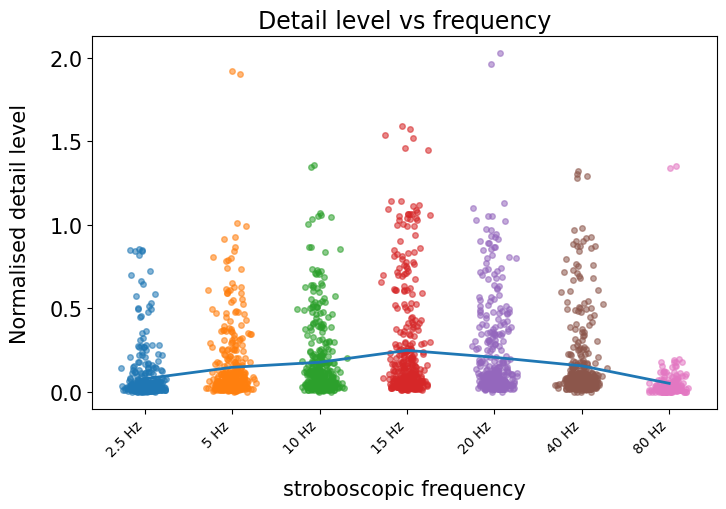

e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the e

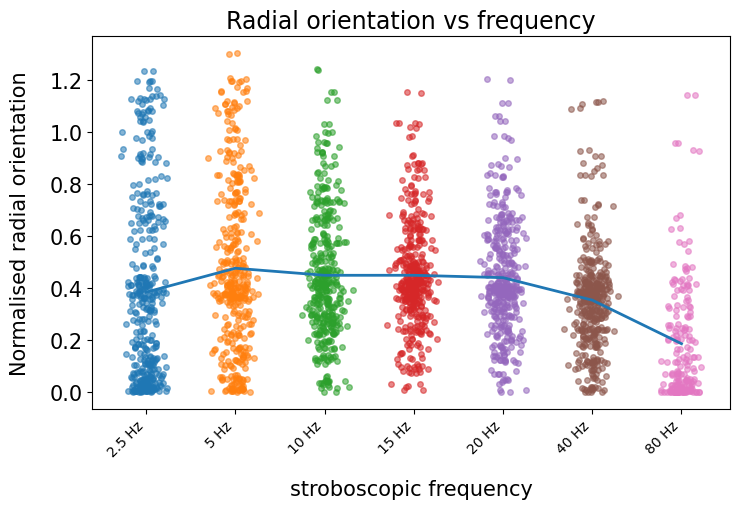

e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the e

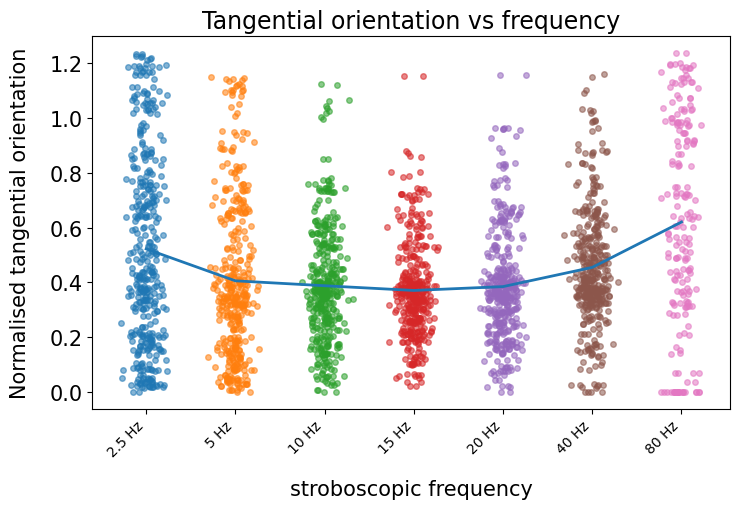

e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the e

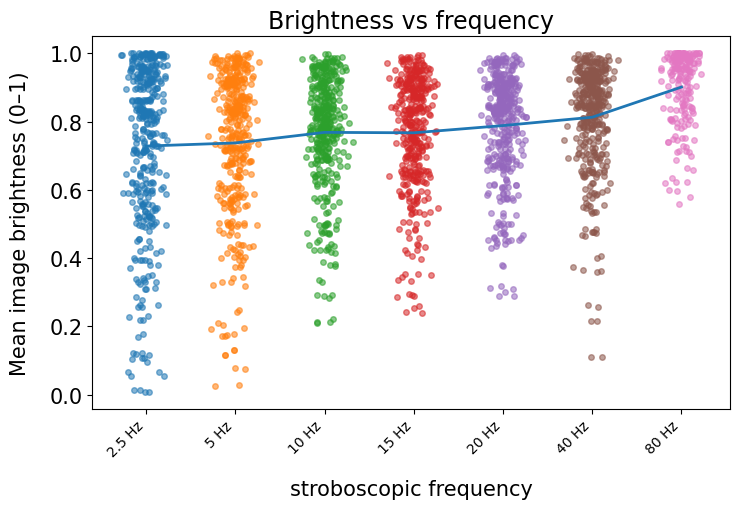

e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the e

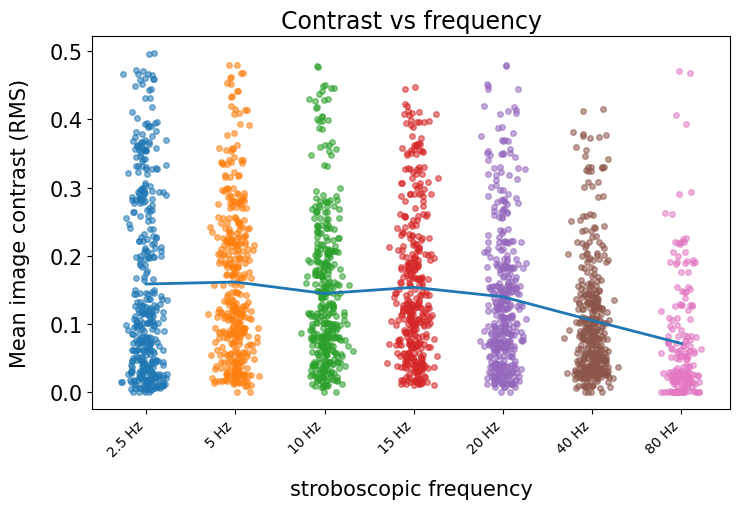


================ Omnibus main effects of frequency (LR test; Holm–Bonferroni corrected) ================

detail: χ²(6) = inf, p < .001
r_directionality: χ²(6) = NA, p = 1.000
theta_directionality: χ²(6) = -inf, p = 1.000
brightness: χ²(6) = NA, p = 1.000
contrast: χ²(6) = NA, p = 1.000


,feature,n,n_participants,n_frequencies,chi2,df,p_raw,p_adj,converged_full
0,detail,2564,99,7,inf,6,0.0,0.0,True
1,r_directionality,2564,99,7,NaN,6,NaN,1.0,True
2,theta_directionality,2564,99,7,-inf,6,1.0,1.0,True
3,brightness,2564,99,7,NaN,6,NaN,1.0,True
4,contrast,2564,99,7,NaN,6,NaN,1.0,True


In [22]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# ============================================================
# VizEx experimental analysis (single experiment)
# - Mixed model ANOVA-style test: main effect of frequency, random intercept for participant
# - Uses all available frequencies in condition_hz
# - Excludes validation/image trials
# ============================================================

text_size = 15
main_title_size = int(text_size * 1.15)
labelpad = 14

# ----------------------------
# Helpers: APA-ish formatting + Holm–Bonferroni
# ----------------------------

def _fmt_num(x, digits=3):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return "NA"
    return f"{x:.{digits}f}"

def _fmt_p_apa(p, *, threshold=0.001, digits=3):
    if p is None or (isinstance(p, float) and np.isnan(p)):
        return "p = NA"
    if float(p) < threshold:
        return "p < .001"
    pr = round(float(p), digits)
    s = f"{pr:.{digits}f}"
    return f"p = {s[1:]}" if s.startswith("0") else f"p = {s}"

def holm_bonferroni_adjust(pvals):
    pvals = np.asarray(pvals, dtype=float)
    m = len(pvals)
    order = np.argsort(pvals)
    ranked = pvals[order]
    adj_ranked = np.empty(m, dtype=float)
    running_max = 0.0
    for j, p in enumerate(ranked, start=1):
        adj = (m - j + 1) * p
        running_max = max(running_max, adj)
        adj_ranked[j - 1] = min(running_max, 1.0)
    out = np.empty(m, dtype=float)
    out[order] = adj_ranked
    return out

def apa_lrtest_string(chi2, df, p):
    return f"χ²({int(df)}) = {_fmt_num(chi2, 2)}, {_fmt_p_apa(p)}"

# ----------------------------
# Data prep
# ----------------------------

def prepare_experimental_vizex(feature: str, datasets: dict) -> pd.DataFrame:
    """
    Returns df with:
      participant_code, condition_hz (float), feature (float)
    Experimental trials only (LIGHT), excluding validation/image and postq.
    """
    df = datasets["vizex"]["df"].copy()

    # Prefer explicit flags if present
    if "stimulus_type" in df.columns:
        df = df[df["stimulus_type"].astype(str).str.upper().eq("LIGHT")].copy()
    elif "condition_type" in df.columns:
        # fallback: validation is IMAGE; experimental/control are light-based
        df = df[~df["condition_type"].astype(str).str.upper().eq("VALIDATION")].copy()

    # Require frequency
    if "condition_hz" not in df.columns:
        raise KeyError("Expected column 'condition_hz' in datasets['vizex']['df'].")

    df["condition_hz"] = pd.to_numeric(df["condition_hz"], errors="coerce")
    df[feature] = pd.to_numeric(df[feature], errors="coerce")

    df = df.dropna(subset=["participant_code", "condition_hz", feature]).copy()

    # Use ordered categorical for nicer plots (sorted by numeric Hz)
    hz_levels = sorted(df["condition_hz"].unique().tolist())
    df["hz_cat"] = pd.Categorical(df["condition_hz"], categories=hz_levels, ordered=True)

    return df

# ----------------------------
# Model: MixedLM with LR test for main effect of frequency
# ----------------------------

def run_frequency_mixedlm(feature: str, df: pd.DataFrame):
    """
    Fit:
      full: feature ~ C(hz_cat) + (1|participant)
      null: feature ~ 1 + (1|participant)
    LR test full vs null gives omnibus main effect of frequency (ANOVA-style).
    """
    df = df.copy()
    full = smf.mixedlm(f"{feature} ~ C(hz_cat)", df, groups=df["participant_code"])
    null = smf.mixedlm(f"{feature} ~ 1", df, groups=df["participant_code"])

    # robust-ish optimizer loop
    methods = ["lbfgs", "bfgs", "cg", "powell", "nm"]
    def _fit(model):
        last = None
        for meth in methods:
            try:
                m = model.fit(reml=False, method=meth, maxiter=2000, disp=False)
                last = m
                if getattr(m, "converged", False):
                    break
            except Exception:
                continue
        if last is None:
            raise RuntimeError("MixedLM fit failed for all optimizers.")
        return last

    m_full = _fit(full)
    m_null = _fit(null)

    # LR test
    llf_full = float(m_full.llf)
    llf_null = float(m_null.llf)
    chi2 = 2.0 * (llf_full - llf_null)

    # df = (#levels - 1)
    n_levels = int(df["hz_cat"].cat.categories.size)
    df_chi = max(n_levels - 1, 1)

    # p-value from chi-square via statsmodels (no scipy dependency assumption)
    # statsmodels has chisqprob deprecated; use survival fn from scipy if available.
    try:
        from scipy.stats import chi2 as _chi2
        p = float(_chi2.sf(chi2, df_chi))
    except Exception:
        p = np.nan  # if scipy unavailable in your environment

    return m_full, m_null, chi2, df_chi, p

# ----------------------------
# Plot: many frequencies displayed cleanly
# ----------------------------

def plot_feature_vs_frequency(feature: str, df: pd.DataFrame, *, feature_name: str, y_label: str):
    """
    Jittered scatter per frequency + mean marker per frequency.
    Designed for many frequencies (labels are '2.5 Hz', '5 Hz', ...).
    """
    rng = np.random.RandomState(0)
    jitter = 0.10

    hz_levels = list(df["hz_cat"].cat.categories)
    labels = [f"{_fmt_num(hz, 1).rstrip('0').rstrip('.')} Hz" for hz in hz_levels]
    x_pos = np.arange(len(hz_levels), dtype=float)

    fig_w = max(7.5, 0.55 * len(hz_levels))
    fig, ax = plt.subplots(figsize=(fig_w, 5.2))

    # scatter
    for i, hz in enumerate(hz_levels):
        vals = df.loc[df["condition_hz"] == hz, feature].to_numpy(dtype=float)
        if vals.size == 0:
            continue
        xs = x_pos[i] + rng.normal(0, jitter, size=vals.size)
        ax.scatter(xs, vals, s=16, alpha=0.55)

    # means
    means = df.groupby("condition_hz")[feature].mean().reindex(hz_levels).to_numpy(dtype=float)
    ax.plot(x_pos, means, linewidth=2)

    ax.set_title(f"{feature_name} vs frequency", fontsize=main_title_size)
    ax.set_ylabel(y_label, fontsize=text_size, labelpad=labelpad)
    ax.set_xlabel("stroboscopic frequency", fontsize=text_size, labelpad=labelpad)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=10)
    ax.tick_params(axis="y", labelsize=text_size)

    plt.tight_layout()
    plt.show()

# ----------------------------
# Master runner (5 features)
# ----------------------------

def run_vizex_experimental_analysis(datasets: dict):
    features = [
        ("detail",               "Detail level",           "Normalised detail level"),
        ("r_directionality",     "Radial orientation",     "Normalised radial orientation"),
        ("theta_directionality", "Tangential orientation", "Normalised tangential orientation"),
        ("brightness",           "Brightness",             "Mean image brightness (0–1)"),
        ("contrast",             "Contrast",               "Mean image contrast (RMS)"),
    ]

    rows = []
    for feature, feature_name, y_label in features:
        df = prepare_experimental_vizex(feature, datasets)

        m_full, m_null, chi2, df_chi, p = run_frequency_mixedlm(feature, df)

        rows.append({
            "feature": feature,
            "n": len(df),
            "n_participants": df["participant_code"].nunique(),
            "n_frequencies": int(df["hz_cat"].cat.categories.size),
            "chi2": chi2,
            "df": df_chi,
            "p_raw": p,
            "converged_full": getattr(m_full, "converged", None),
        })

        plot_feature_vs_frequency(feature, df, feature_name=feature_name, y_label=y_label)

    results = pd.DataFrame(rows)
    results["p_adj"] = holm_bonferroni_adjust(results["p_raw"].to_numpy(dtype=float))

    print("\n================ Omnibus main effects of frequency (LR test; Holm–Bonferroni corrected) ================\n")
    for _, r in results.iterrows():
        print(f"{r['feature']}: {apa_lrtest_string(r['chi2'], r['df'], r['p_adj'])}")

    display(results[["feature", "n", "n_participants", "n_frequencies", "chi2", "df", "p_raw", "p_adj", "converged_full"]])
    return results

# ---------------- RUN ----------------
vizex_experimental_results = run_vizex_experimental_analysis(datasets)


## extra 15 hz test


Trials included: 788
Participants: 99

================ Mixed model result (trial-level) ================

         Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  detail 
No. Observations:  788      Method:              ML     
No. Groups:        99       Scale:               0.0372 
Min. group size:   6        Log-Likelihood:      62.6754
Max. group size:   8        Converged:           Yes    
Mean group size:   8.0                                  
--------------------------------------------------------
                Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept       0.177    0.023 7.612 0.000  0.131  0.222
C(hz_cat)[T.15] 0.072    0.014 5.202 0.000  0.045  0.099
Group Var       0.044    0.038                          


Effect (15 Hz vs 10 Hz): b = 0.072, SE = 0.014, z = 5.20, p < .001

================ Paired t-test (participant means) ================

t(98) = -3.39, p = .00

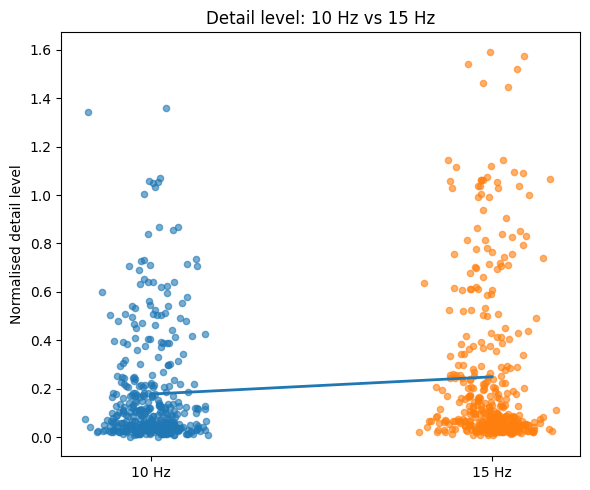

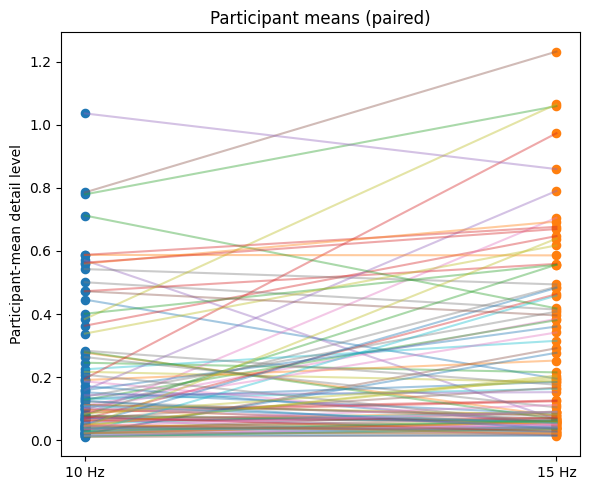

In [23]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# ============================================================
# 10 Hz vs 15 Hz analysis (detail only)
# ============================================================

def run_detail_10_vs_15(datasets):

    # ----------------------------
    # Prepare data
    # ----------------------------
    df = prepare_experimental_vizex("detail", datasets).copy()

    # Keep only 10 Hz (3) and 15 Hz (4)
    df = df[df["condition_hz"].isin([10, 15])].copy()

    df["hz_cat"] = pd.Categorical(df["condition_hz"],
                                  categories=[10, 15],
                                  ordered=True)

    print("\nTrials included:", len(df))
    print("Participants:", df["participant_code"].nunique())

    # ============================================================
    # Mixed model (trial-level)
    # detail ~ condition + (1|participant)
    # ============================================================

    model = smf.mixedlm("detail ~ C(hz_cat)",
                        df,
                        groups=df["participant_code"])

    m = model.fit(reml=False, method="lbfgs")

    print("\n================ Mixed model result (trial-level) ================\n")
    print(m.summary())

    # Extract coefficient for 15 Hz relative to 10 Hz
    coef_name = "C(hz_cat)[T.15]"
    if coef_name in m.params:
        b = m.params[coef_name]
        se = m.bse[coef_name]
        z = b / se
        from scipy.stats import norm
        p = 2 * norm.sf(abs(z))
        print(f"\nEffect (15 Hz vs 10 Hz): b = {_fmt_num(b)}, "
              f"SE = {_fmt_num(se)}, z = {_fmt_num(z,2)}, {_fmt_p_apa(p)}")

    # ============================================================
    # Paired t-test on participant means (robustness check)
    # ============================================================

    means = (
        df.groupby(["participant_code", "condition_hz"])["detail"]
        .mean()
        .unstack()
    )

    means = means.dropna()

    from scipy.stats import ttest_rel
    t, p_t = ttest_rel(means[10], means[15])

    print("\n================ Paired t-test (participant means) ================\n")
    print(f"t({len(means)-1}) = {_fmt_num(t,2)}, {_fmt_p_apa(p_t)}")

    # ============================================================
    # Plot 1: raw trials (jittered)
    # ============================================================

    fig, ax = plt.subplots(figsize=(6,5))

    rng = np.random.RandomState(0)
    jitter = 0.07
    x_pos = [0, 1]

    for i, hz in enumerate([10, 15]):
        vals = df.loc[df["condition_hz"] == hz, "detail"].to_numpy()
        xs = x_pos[i] + rng.normal(0, jitter, size=len(vals))
        ax.scatter(xs, vals, alpha=0.6, s=20)

    means_raw = df.groupby("condition_hz")["detail"].mean()
    ax.plot(x_pos, means_raw.loc[[10,15]], linewidth=2)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(["10 Hz", "15 Hz"])
    ax.set_ylabel("Normalised detail level")
    ax.set_title("Detail level: 10 Hz vs 15 Hz")

    plt.tight_layout()
    plt.show()

    # ============================================================
    # Plot 2: participant means + connecting lines
    # ============================================================

    fig, ax = plt.subplots(figsize=(6,5))

    for _, row in means.iterrows():
        ax.plot([0,1], [row[10], row[15]], alpha=0.4)

    ax.scatter(np.zeros(len(means)), means[10], s=35)
    ax.scatter(np.ones(len(means)), means[15], s=35)

    ax.set_xticks([0,1])
    ax.set_xticklabels(["10 Hz", "15 Hz"])
    ax.set_ylabel("Participant-mean detail level")
    ax.set_title("Participant means (paired)")

    plt.tight_layout()
    plt.show()

    return m, means


# ---------------- RUN ----------------
detail_10_15_model, detail_10_15_means = run_detail_10_vs_15(datasets)
